In [230]:
import pandas as pd
import adata

etfs = ['513500', '560050', '511260', '159934', '159726']

df = pd.DataFrame()

for i in etfs:
    etf_df = adata.fund.market.get_market_etf(i, start_date='2017-01', end_date='2024-12', k_type=3)
    etf_df['close'] = etf_df['close'].astype(float)
    pivot_df = etf_df.pivot(index='trade_date', columns='fund_code', values='close')
    df = pd.concat([df, pivot_df], axis=1)

change_df = df.pct_change().dropna()
change_df

fund_code,513500,560050,511260,159934,159726
trade_date,,,,,
2021-12-31,0.032258,0.015275,0.006732,0.011485,0.017727
2022-01-28,-0.097917,-0.065196,0.007264,-0.012739,0.058402
2022-02-28,-0.016936,-0.004292,-0.002093,0.051332,-0.026137
2022-03-31,0.086139,-0.077586,0.000753,0.013074,-0.022863
2022-04-29,-0.033886,-0.037383,0.002755,0.028707,0.022380
2022-05-31,-0.026866,0.020631,0.004940,-0.016897,0.005970
2022-06-30,-0.083589,0.114150,-0.001851,-0.014844,-0.004946
2022-07-29,0.091213,-0.075774,0.010284,-0.019826,-0.185885
2022-08-31,0.000767,-0.019630,0.009404,0.003506,-0.015873


In [231]:
import numpy as np
from arch import arch_model
from scipy.optimize import minimize


def forecast_volatility(returns, p=1, q=1, horizon=1):
    model = arch_model(returns, vol='GARCH', p=p, q=q, rescale=False)
    results = model.fit(disp='off')
    forecast = results.forecast(horizon=horizon)
    monthly_vol = np.sqrt(forecast.variance.values[-1, -1])
    return monthly_vol * np.sqrt(12)  # 年化月度波动率

def objective(weights, vol_pred, target_vol):
    portfolio_vol = np.sqrt(np.dot(weights**2, vol_pred**2))
    return np.abs(portfolio_vol - target_vol)

def constraint(weights):
    return np.sum(weights) - 1

def optimize_weights(vol_pred, target_vol, min_weight=0.05):
    n_assets = len(vol_pred)
    initial_weights = np.array([1/n_assets] * n_assets)
    bounds = tuple((min_weight, 1) for _ in range(n_assets))
    
    constraints = ({'type': 'eq', 'fun': constraint})
    
    result = minimize(objective, initial_weights, args=(vol_pred, target_vol),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result.x

def target_volatility_strategy(returns, target_vol, min_weight=0.05, lookback=60):
    n_assets = returns.shape[1]
    weights = np.zeros((len(returns), n_assets))
    
    # 创建一个日期索引
    dates = returns.index
    
    for t in range(lookback, len(returns)):
        historical_returns = returns.iloc[t-lookback:t]
        vol_pred = np.array([forecast_volatility(historical_returns[col]) for col in historical_returns.columns])
        
        optimized_weights = optimize_weights(vol_pred, target_vol, min_weight)
        weights[t] = optimized_weights
    
    # 创建一个 DataFrame，索引为日期，列名为资产名称
    weights_df = pd.DataFrame(weights[lookback:], index=dates[lookback:], columns=returns.columns)
    # 保留小数点后两位
    weights_df = weights_df.round(2)
    
    strategy_returns = (weights_df * returns.iloc[lookback:]).sum(axis=1)
    
    return strategy_returns, weights_df

def equal_weight_strategy(returns):
    n_assets = returns.shape[1]
    weights = np.ones((len(returns), n_assets)) * (1 / n_assets)  # 等权重分配
    
    # 创建一个日期索引
    dates = returns.index
    
    # 创建一个 DataFrame，索引为日期，列名为资产名称
    weights_df = pd.DataFrame(weights, index=dates, columns=returns.columns)
    
    # 计算策略收益
    strategy_returns = (weights_df * returns).sum(axis=1)
    
    return strategy_returns, weights_df

In [232]:
lookback_p = 8
strategy_returns, weights_df = target_volatility_strategy(change_df, 0.07, lookback=lookback_p)
eq_strategy_returns, eq_weights_df = equal_weight_strategy(change_df.iloc[lookback_p:])

/opt/conda/lib/python3.11/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/opt/conda/lib/python3.11/site-packages/scipy/optimize/_slsqp_py.py:438: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/opt/conda/lib/python3.11/site-packages/scipy/optimize/_slsqp_py.py:492: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])
/opt/conda/lib/python3.11/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/opt/conda/lib/python3.11/site-packages/scipy/optimize/_slsqp_py.py:438: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/opt/conda/lib/python

/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20928 (\N{CJK UNIFIED IDEOGRAPH-51C0}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


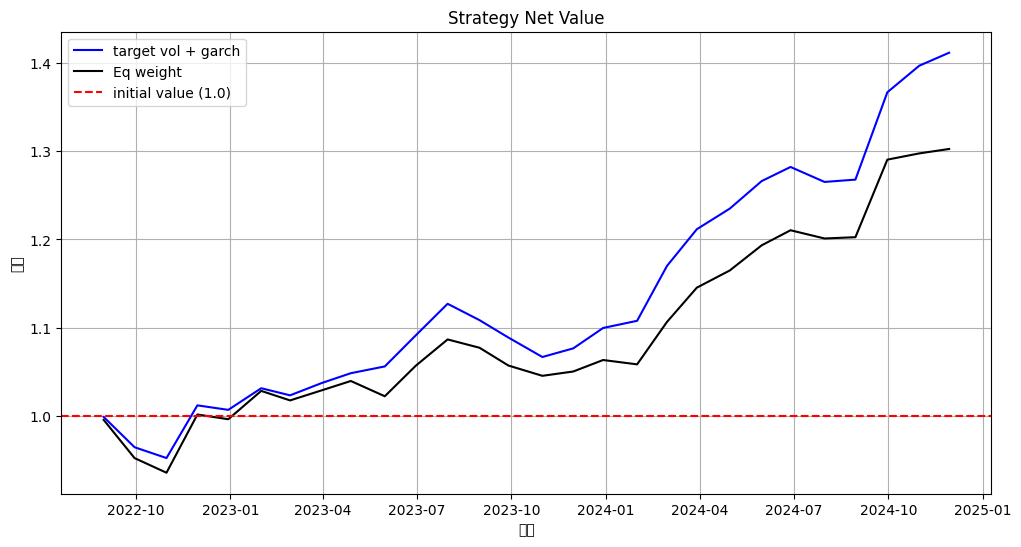

In [233]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 计算净值
initial_value = 1.0  # 初始净值
net_value = (1 + strategy_returns).cumprod() * initial_value
net_value.index = pd.to_datetime(net_value.index)


initial_value = 1.0  # 初始净值
eq_net_value = (1 + eq_strategy_returns).cumprod() * initial_value
eq_net_value.index = pd.to_datetime(eq_net_value.index)

start_date = max(net_value.index[0], eq_net_value.index[0])
net_value = net_value[net_value.index >= start_date]
eq_net_value = eq_net_value[eq_net_value.index >= start_date]

# 绘制净值曲线
plt.figure(figsize=(12, 6))
plt.plot(net_value.index, net_value, label='target vol + garch', color='blue')
plt.plot(eq_net_value.index, eq_net_value, label='Eq weight', color='black')
plt.title('Strategy Net Value')
plt.xlabel('日期')
plt.ylabel('净值')
plt.axhline(y=1, color='r', linestyle='--', label='initial value (1.0)')
plt.legend()
plt.grid()
plt.show()

In [234]:
weights_df.tail(1)

fund_code,513500,560050,511260,159934,159726
trade_date,,,,,
2024-11-29,0.25,0.08,0.24,0.24,0.18


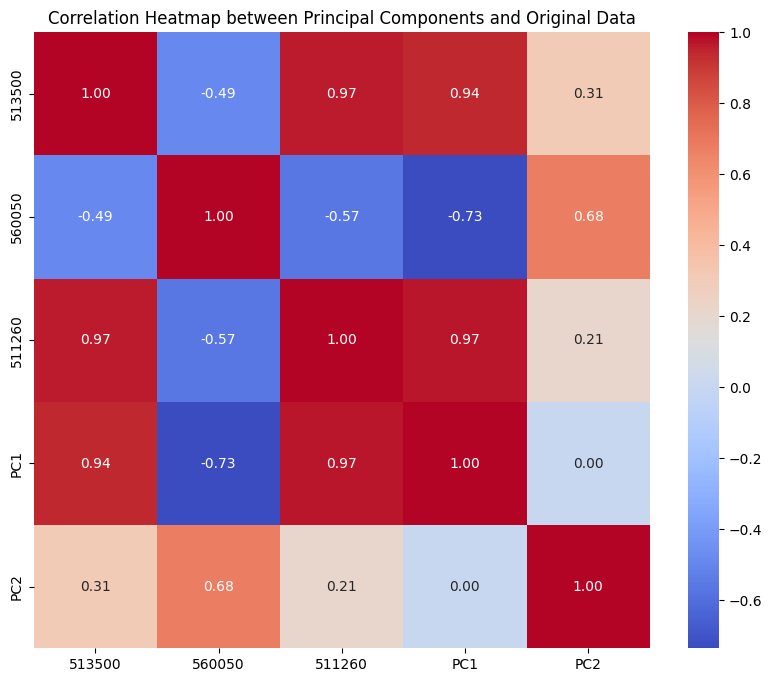

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 假设 df 是您的数据框，并且包含特征 '513500', '560050', '511260'
# 选择要使用的特征
X = df[['513500', '560050', '511260']].dropna().values  # 去除缺失值

# 标准化数据
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 创建 PCA 对象并进行拟合转换
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# 计算相关性矩阵
correlation_matrix = pd.concat([df.reset_index(drop=True), pc_df], axis=1).corr()

# 绘制热力图
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Heatmap between Principal Components and Original Data')
plt.show()


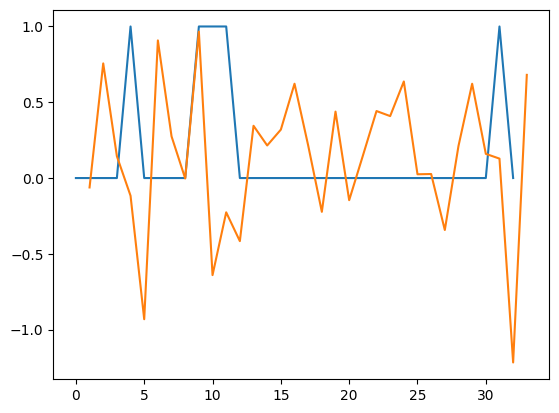

In [97]:
from hmmlearn import hmm

states_X = pc_df[['PC1']].diff().dropna()

model = hmm.GaussianHMM(n_components=2, covariance_type="diag", n_iter=1000, random_state=10)
model.fit(states_X)
states = model.predict(states_X)

plt.plot(states)
plt.plot(states_X)

In [90]:
pip install tensorflow -i https://mirrors.aliyun.com/pypi/simple

Looking in indexes: https://mirrors.aliyun.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 MB 5.7 MB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 9.3 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 7.2 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 9.2 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 12.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml_dtypes 0.5.0
    Uninstalling ml_dtypes-0.5.0:
      Successfully uninstalled ml_dtypes-0.5.0
Note: you may need to restart the kernel to use updated packages.
